# Use SHAP analysis to understand the percentage of importance of each omic type

We will be using LinearExplainer


Computes SHAP values for a linear model, optionally accounting for inter-feature correlations.

This computes the SHAP values for a linear model and can account for the correlations among the input features. Assuming features are independent leads to interventional SHAP values which for a linear model are coef[i] * (x[i] - X.mean(0)[i]) for the ith feature. If instead we account for correlations then we prevent any problems arising from colinearity and share credit among correlated features. Accounting for correlations can be computationally challenging, but LinearExplainer uses sampling to estimate a transform that can then be applied to explain any prediction of the mode

In [135]:
import shap
import joblib
import pandas as pd
import re
import numpy as np
import seaborn as sns
import pickle

import matplotlib.pyplot as plt
from matplotlib.pyplot import savefig, close

from sklearn.metrics import mean_absolute_error

In [136]:
table_importance = {}
table_mean_importance = {}

In [137]:
# Function to convert probes names
def convert_probe_names(labels, probe_info): 
    """Convert probe text to also contain the associated gene/genes"""
    # Create a new column 'genes_clean' by splitting 'UCSC_RefGene_Name' and collapsing unique values
    probe_info['genes_clean'] = probe_info['UCSC_RefGene_Name'].apply(lambda x: ';'.join(sorted(set(str(x).split(';')))) if pd.notnull(x) else '')
    # Create a new column 'feature_full_name' by concatenating 'IlmnID' and 'genes_clean'
    probe_info['feature_full_name'] = probe_info['IlmnID'] + probe_info['genes_clean'].apply(lambda x: ' - ' + x if x != "" else "")
    probe_info = probe_info.set_index("IlmnID")

    for i in range(len(labels)): 
        labels[i] = probe_info.loc[labels[i], "feature_full_name"]
    
    return labels

def convert_beta_to_m(meth):
    """Convert beta values to M values"""
    beta_columns = meth.columns
    m_columns = []

    for beta_column in beta_columns:
        if beta_column == "probe": 
            m_columns.append(meth["probe"])
        else: 
            m_columns.append(np.log2(meth[beta_column] / (1 - meth[beta_column])))

    m_dataframe = pd.concat(m_columns, axis=1)

    return m_dataframe

def normalize_score(shap_values_df): 
    """Normalize the score"""
    mean_abs_scores = shap_values_df.abs().mean()

    normalized_scores = (mean_abs_scores / mean_abs_scores.sum()) * 100

    normalized_scores_df = pd.DataFrame({
        'column_name': mean_abs_scores.index,
        'score': mean_abs_scores.values,
        'normalized_score': normalized_scores.values
    })
    return normalized_scores_df[normalized_scores_df.score != 0]



In [138]:
## Load probes annotation
probe_info = pd.read_csv("../../metadata/methylation_epic_v1.0b5.csv")

Columns (2,4,42,47) have mixed types. Specify dtype option on import or set low_memory=False.


# Hist + Meth

In [139]:
# Load models
lung_hist_meth = joblib.load("../../results/9.multi_modal_models/lung/1_EN_hist_meth.pipeline.pkl")
ovary_hist_meth = joblib.load("../../results/9.multi_modal_models/ovary/1_EN_hist_meth.pipeline.pkl")


In [140]:
def compute_shap_values_meth_hist(pipeline, tissue, optuna):
    """Compute SHap values using linearExplainer"""
    
    if tissue == "lung": 
        tissue_name = "Lung"
    else: 
        tissue_name = "Ovary"

    # Load the coefs (Methylation data)
    coef = pd.read_csv(f"../../results/9.multi_modal_models/{tissue}/1_EN_hist_meth_feature_importance.csv")
    
    # Load optuna to get the best hist features and load the corresponding file
    optuna = pd.read_csv(f"../../results/9.multi_modal_models/{tissue}/{optuna}")
    hist_features = optuna.sort_values("value").iloc[0].params_histological_features
    hist_data_file = f"../../data/features_histology/{tissue}/{tissue}_features_{hist_features}.pkl"    
    hist_data_df = pickle.load(open(hist_data_file, "rb"))
    hist_data_df.columns = [f'hist_feature_{i}' for i in range(len(hist_data_df.columns))]
        
    # Select probes
    coef_meth = [probe for probe in coef.probe if probe.startswith("cg")]

    # Load meth data
    meth = pd.read_csv(f"../../data/methylation_{tissue}.csv")
    test_set = pd.read_csv(f"../../metadata/{tissue}_test_metadata.csv")
    metadata = pd.read_csv(f"../../metadata/{tissue}_annotation_meth.csv")

    meth = convert_beta_to_m(meth)

    # Filer out samples
    multi_modal_table = "../../metadata/sample_ids_multiomics_updated_tl_data.csv"
    multi_modal_table = pd.read_csv(multi_modal_table)
    
    filtered_multi_modal_table = multi_modal_table[multi_modal_table['tissue'] == tissue_name]
    complete_samples = filtered_multi_modal_table[(filtered_multi_modal_table["metadata"]) == 1 & (filtered_multi_modal_table["gene_expression"]) & (filtered_multi_modal_table["metilation"]) &  (filtered_multi_modal_table["telemore"])]

    # Subset samples that are also in histology
    complete_samples = complete_samples[complete_samples.sample_id.isin(hist_data_df.index)]
    

    # Parse metadata and subset test set
    meth.columns = [re.sub(r"-SM-.*", "", i) for i in meth.columns.to_list()]
    metadata["sample_id"] = [re.sub(r"-SM-.*", "", i) for i in metadata.Sample_ID.to_list()]

    metadata_test = metadata.query("sample_id in @test_set.sample_id")

    # Filter for probes in the model
    meth.index = meth.probe
    meth = meth.reindex(coef_meth)
    meth = meth.drop("probe", axis = 1)

    # Transpose the data
    meth = meth.T


    ### Subset the test set for meth data
    complete_samples_age = complete_samples.copy()
    complete_samples_age = complete_samples_age.set_index("sample_id")

    complete_samples_age_train = complete_samples_age[~complete_samples_age.index.isin(test_set["sample_id"])]

    hist_data_df_train = hist_data_df.loc[complete_samples_age_train.index]
    hist_data_df_test = hist_data_df.loc[test_set.sample_id]

    meth_train = meth[meth.index.isin(complete_samples_age_train.index)]
    meth_test = meth[meth.index.isin(metadata_test.sample_id)]

    # Concatenate data from histology
    X_train_filtered = pd.concat([meth_train, hist_data_df_train], axis = 1)
    X_test_filtered = pd.concat([meth_test, hist_data_df_test], axis = 1)
        
    # Normalize the data 
    qt_norm = pipeline[0]
    train_norm = qt_norm.transform(X_train_filtered)
    test_norm = qt_norm.transform(X_test_filtered)


    explainer = shap.LinearExplainer(model = pipeline[1], masker = shap.maskers.Independent(train_norm))
    shap_values = explainer.shap_values(test_norm)

    return(shap_values, pd.DataFrame(shap_values, columns=X_test_filtered.columns.tolist()), test_norm)

In [141]:
shap_values_lung_meth_hist, shap_values_lung_meth_hist_df, meth_hist_test_norm_lung = compute_shap_values_meth_hist(lung_hist_meth, "lung", "1_optuna_table.csv")
shap_values_ovary_meth_hist, shap_values_ovary_meth_hist_df, meth_his_test_norm_ovary = compute_shap_values_meth_hist(ovary_hist_meth, "ovary", "1_optuna_table.csv")


In [142]:
shap_values_lung_df_norm = normalize_score(shap_values_lung_meth_hist_df)
shap_values_ovary_df_norm = normalize_score(shap_values_ovary_meth_hist_df)

### Lung

In [143]:
subset_df_cg = shap_values_lung_df_norm[shap_values_lung_df_norm['column_name'].str.startswith('cg')]
subset_df_hist = shap_values_lung_df_norm[shap_values_lung_df_norm['column_name'].str.startswith('hist_feature')]

# Sum the "normalized_scores" column for the subset
sum_normalized_scores = [subset_df_cg.normalized_score.sum(), subset_df_hist.normalized_score.sum()]
avg_normalized_scores = [subset_df_cg.normalized_score.mean(), subset_df_hist.normalized_score.mean()]

table_importance["lung_meth_hist"] = {"hist": sum_normalized_scores[1], "meth": sum_normalized_scores[0]}
table_mean_importance["lung_meth_hist"] = {"hist": avg_normalized_scores[1], "meth": avg_normalized_scores[0]}


### Ovary

In [144]:
subset_df_cg = shap_values_ovary_df_norm[shap_values_ovary_df_norm['column_name'].str.startswith('cg')]
subset_df_hist = shap_values_ovary_df_norm[shap_values_ovary_df_norm['column_name'].str.startswith('hist_feature')]

# Sum the "normalized_scores" column for the subset
sum_normalized_scores = [subset_df_cg.normalized_score.sum(), subset_df_hist.normalized_score.sum()]
avg_normalized_scores = [subset_df_cg.normalized_score.mean(), subset_df_hist.normalized_score.mean()]

table_importance["ovary_meth_hist"] = {"hist": sum_normalized_scores[1], "meth": sum_normalized_scores[0]}
table_mean_importance["ovary_meth_hist"] = {"hist": avg_normalized_scores[1], "meth": avg_normalized_scores[0]}


In [145]:
print(subset_df_cg.shape)
print(subset_df_hist.shape)

(434, 3)
(13, 3)


In [146]:
table_importance

{'lung_meth_hist': {'hist': 1.3493809401835442, 'meth': 98.65061905981645},
 'ovary_meth_hist': {'hist': 4.203376531135257, 'meth': 95.79662346886477}}

In [147]:
table_mean_importance

{'lung_meth_hist': {'hist': 0.07102004948334444, 'meth': 0.09476524405361811},
 'ovary_meth_hist': {'hist': 0.32333665624117364, 'meth': 0.22072954716328286}}

# Meth + Gexp

In [148]:
# Load models
lung_gexp_meth = joblib.load("../../results/9.multi_modal_models/lung/5_EN_hist_meth.pipeline.pkl")
ovary_gexp_meth = joblib.load("../../results/9.multi_modal_models/ovary/5_EN_hist_meth.pipeline.pkl")


In [149]:
def split_in_train_test(meth, age_data, test_set):
    """Split the dataset into train and test"""
    #Metadata
    metadata_test = age_data.loc[age_data["sample_id"].isin(test_set["sample_id"])]
    metadata_train = age_data.loc[~age_data["sample_id"].isin(test_set["sample_id"])]
    #Age data
    y_test = list(metadata_test["age"])
    y_train = list(metadata_train["age"])

    X_train = meth.loc[metadata_train.sample_id]
    X_test = meth.loc[metadata_test.sample_id]

    return(X_train, X_test, y_train, y_test)

In [150]:
def compute_shap_values_meth_gexp(pipeline, tissue):
    """Compute Shap values using linearExplainer"""
    
    if tissue == "lung": 
        tissue_name = "Lung"
    else: 
        tissue_name = "Ovary"

    # Load the coefs (Methylation data)
    coef = pd.read_csv(f"../../results/9.multi_modal_models/{tissue}/5_EN_hist_meth_feature_importance.csv")
    
    hist_data_file = f"../../data/features_histology/{tissue}/{tissue}_features_mean256_cls4k.pkl"    
    hist_data_df = pickle.load(open(hist_data_file, "rb"))
    hist_data_df.columns = [f'hist_feature_{i}' for i in range(len(hist_data_df.columns))]
        
    # Select probes
    coef_meth = [probe for probe in coef.features if probe.startswith("cg")]
    coef_gexp = [gene for gene in coef.features if gene.startswith("ENS")]

    # Load meth data
    meth = pd.read_csv(f"../../data/methylation_{tissue}.csv")
    test_set = pd.read_csv(f"../../metadata/{tissue}_test_metadata.csv")
    metadata = pd.read_csv(f"../../metadata/{tissue}_annotation_meth.csv")

    meth = convert_beta_to_m(meth)

    # Filer out samples
    multi_modal_table = "../../metadata/sample_ids_multiomics_updated_tl_data.csv"
    multi_modal_table = pd.read_csv(multi_modal_table)
    
    filtered_multi_modal_table = multi_modal_table[multi_modal_table['tissue'] == tissue_name]
    complete_samples = filtered_multi_modal_table[(filtered_multi_modal_table["metadata"]) == 1 & (filtered_multi_modal_table["gene_expression"]) & (filtered_multi_modal_table["metilation"]) &  (filtered_multi_modal_table["telemore"])]

    # Subset samples that are also in histology
    complete_samples = complete_samples[complete_samples.sample_id.isin(hist_data_df.index)]
    

    # Parse metadata and subset test set
    meth.columns = [re.sub(r"-SM-.*", "", i) for i in meth.columns.to_list()]
    metadata["sample_id"] = [re.sub(r"-SM-.*", "", i) for i in metadata.Sample_ID.to_list()]

    
    # Filter for probes in the model
    meth.index = meth.probe
    meth = meth.reindex(coef_meth)
    meth = meth.drop("probe", axis = 1)

    # Transpose the data
    meth = meth.T

    ### Subset the test set for meth data
    complete_samples_age = complete_samples.copy()
    complete_samples_age = complete_samples_age.set_index("sample_id")

    # Load Gexp data
    X_coding_log = pd.read_csv(f"../../data/X_coding_{tissue}_log2.csv",
                            header=0, index_col=0)
    X_coding_log = X_coding_log.loc[complete_samples.sample_id]
    X_coding_log = X_coding_log[coef_gexp]

    # Combine both dataset
    multi_omics_data = pd.concat([meth, X_coding_log], axis = 1)

    #Split in Train and test data
    X_train, X_test, y_train, y_test = split_in_train_test(multi_omics_data, complete_samples, test_set)
    
    # Normalize the data 
    qt_norm = pipeline[0]
    train_norm = qt_norm.transform(X_train)
    test_norm = qt_norm.transform(X_test)

    
    explainer = shap.LinearExplainer(model = pipeline[1], masker = shap.maskers.Independent(train_norm))
    shap_values = explainer.shap_values(test_norm)

    return(shap_values, pd.DataFrame(shap_values, columns=X_test.columns.tolist()), test_norm)

In [151]:
shap_values_lung_meth_gexp, shap_values_lung_meth_gexp_df, meth_gexp_test_norm_lung = compute_shap_values_meth_gexp(lung_gexp_meth, "lung")
shap_values_ovary_meth_gexp, shap_values_ovary_meth_gexp_df, meth_gexp_test_norm_ovary = compute_shap_values_meth_gexp(ovary_gexp_meth, "ovary")


In [152]:
shap_values_lung_df_norm = normalize_score(shap_values_lung_meth_gexp_df)
shap_values_ovary_df_norm = normalize_score(shap_values_ovary_meth_gexp_df)

### Lung

In [153]:
subset_df_cg = shap_values_lung_df_norm[shap_values_lung_df_norm['column_name'].str.startswith('cg')]
subset_df_ens = shap_values_lung_df_norm[shap_values_lung_df_norm['column_name'].str.startswith('ENS')]

# Sum the "normalized_scores" column for the subset
sum_normalized_scores = [subset_df_cg.normalized_score.sum(), subset_df_ens.normalized_score.sum()]
avg_normalized_scores = [subset_df_cg.normalized_score.mean(), subset_df_ens.normalized_score.mean()]


table_importance["lung_meth_gexp"] = {"gexp": sum_normalized_scores[1], "meth": sum_normalized_scores[0]}
table_mean_importance["lung_meth_gexp"] = {"gexp": avg_normalized_scores[1], "meth": avg_normalized_scores[0]}


### Ovary

In [154]:
subset_df_cg = shap_values_ovary_df_norm[shap_values_ovary_df_norm['column_name'].str.startswith('cg')]
subset_df_ens = shap_values_ovary_df_norm[shap_values_ovary_df_norm['column_name'].str.startswith('ENS')]

# Sum the "normalized_scores" column for the subset
sum_normalized_scores = [subset_df_cg.normalized_score.sum(), subset_df_ens.normalized_score.sum()]
avg_normalized_scores = [subset_df_cg.normalized_score.mean(), subset_df_ens.normalized_score.mean()]

table_importance["ovary_meth_gexp"] = {"gexp": sum_normalized_scores[1], "meth": sum_normalized_scores[0]}
table_mean_importance["ovary_meth_gexp"] = {"gexp": avg_normalized_scores[1], "meth": avg_normalized_scores[0]}


In [155]:
table_importance

{'lung_meth_hist': {'hist': 1.3493809401835442, 'meth': 98.65061905981645},
 'ovary_meth_hist': {'hist': 4.203376531135257, 'meth': 95.79662346886477},
 'lung_meth_gexp': {'gexp': 10.934843153902282, 'meth': 89.06515684609771},
 'ovary_meth_gexp': {'gexp': 15.341813652143625, 'meth': 84.65818634785637}}

In [156]:
table_mean_importance

{'lung_meth_hist': {'hist': 0.07102004948334444, 'meth': 0.09476524405361811},
 'ovary_meth_hist': {'hist': 0.32333665624117364, 'meth': 0.22072954716328286},
 'lung_meth_gexp': {'gexp': 0.32161303393830243, 'meth': 0.19404173604814315},
 'ovary_meth_gexp': {'gexp': 0.2474486072926391, 'meth': 0.19551544191190848}}

# Meth + Gexp + Hist

In [157]:
def compute_shap_values_meth_hist_gexp(pipeline, tissue, optuna):
    """Compute SHap values using linearExplainer"""
    
    if tissue == "lung": 
        tissue_name = "Lung"
    else: 
        tissue_name = "Ovary"

    # Load the coefs (Methylation data)
    coef = pd.read_csv(f"../../results/9.multi_modal_models/{tissue}/7_EN_hist_meth_feature_importance.csv")
    
    # Load optuna to get the best hist features and load the corresponding file
    if tissue == "lung": 
        optuna = pd.read_csv(f"../../results/9.multi_modal_models/{tissue}/{optuna}")
        hist_features = optuna.sort_values("value").iloc[0].params_histological_features
        
    else: 
        #There was an issue with optuna in ovary
        hist_features=  "mean256_cls4k"
    hist_data_file = f"../../data/features_histology/{tissue}/{tissue}_features_{hist_features}.pkl" 
    hist_data_df = pickle.load(open(hist_data_file, "rb"))
    hist_data_df.columns = [f'hist_feature_{i}' for i in range(len(hist_data_df.columns))]
        
    # Select probes
    coef_meth = [probe for probe in coef.features if probe.startswith("cg")]
    coef_gexp = [gene for gene in coef.features if gene.startswith("ENS")]

    # Load meth data
    meth = pd.read_csv(f"../../data/methylation_{tissue}.csv")
    test_set = pd.read_csv(f"../../metadata/{tissue}_test_metadata.csv")
    metadata = pd.read_csv(f"../../metadata/{tissue}_annotation_meth.csv")

    meth = convert_beta_to_m(meth)

    # Filer out samples
    multi_modal_table = "../../metadata/sample_ids_multiomics_updated_tl_data.csv"
    multi_modal_table = pd.read_csv(multi_modal_table)
    
    filtered_multi_modal_table = multi_modal_table[multi_modal_table['tissue'] == tissue_name]
    complete_samples = filtered_multi_modal_table[(filtered_multi_modal_table["metadata"]) == 1 & (filtered_multi_modal_table["gene_expression"]) & (filtered_multi_modal_table["metilation"]) &  (filtered_multi_modal_table["telemore"])]

    # Subset samples that are also in histology
    complete_samples = complete_samples[complete_samples.sample_id.isin(hist_data_df.index)]
    
    # Load Gexp data
    X_coding_log = pd.read_csv(f"../../data/X_coding_{tissue}_log2.csv",
                            header=0, index_col=0)
    X_coding_log = X_coding_log.loc[complete_samples.sample_id]
    X_coding_log = X_coding_log[coef_gexp]


    # Parse metadata and subset test set
    meth.columns = [re.sub(r"-SM-.*", "", i) for i in meth.columns.to_list()]
    metadata["sample_id"] = [re.sub(r"-SM-.*", "", i) for i in metadata.Sample_ID.to_list()]

    metadata_test = metadata.query("sample_id in @test_set.sample_id")

    # Filter for probes in the model
    meth.index = meth.probe
    meth = meth.reindex(coef_meth)
    meth = meth.drop("probe", axis = 1)

    # Transpose the data
    meth = meth.T


    ### Subset the test set for meth data
    complete_samples_age = complete_samples.copy()
    complete_samples_age = complete_samples_age.set_index("sample_id")

    complete_samples_age_train = complete_samples_age[~complete_samples_age.index.isin(test_set["sample_id"])]

    hist_data_df_train = hist_data_df.loc[complete_samples_age_train.index]
    hist_data_df_test = hist_data_df.loc[test_set.sample_id]

    X_gexp_train = X_coding_log.loc[complete_samples_age_train.index]
    X_gexp_test = X_coding_log.loc[test_set.sample_id]
    
    meth_train = meth.loc[complete_samples_age_train.index]
    meth_test = meth.loc[metadata_test.sample_id]
    
    # Concatenate data from histology
    X_train_filtered = pd.concat([meth_train, X_gexp_train, hist_data_df_train, ], axis = 1)
    X_test_filtered = pd.concat([meth_test, X_gexp_test, hist_data_df_test], axis = 1)
    
    # Normalize the data 
    qt_norm = pipeline[0]
    train_norm = qt_norm.transform(X_train_filtered)
    test_norm = qt_norm.transform(X_test_filtered)


    explainer = shap.LinearExplainer(model = pipeline[1], masker = shap.maskers.Independent(train_norm))
    shap_values = explainer.shap_values(test_norm)

    return(shap_values, pd.DataFrame(shap_values, columns=X_test_filtered.columns.tolist()), test_norm)

In [158]:
lung_hist_meth_gexp = joblib.load("../../results/9.multi_modal_models/lung/7_EN_hist_meth.pipeline.pkl")
ovary_hist_meth_gexp = joblib.load("../../results/9.multi_modal_models/ovary/7_EN_hist_meth.pipeline.pkl")


In [159]:
shap_values_lung_meth_hist_gexp, shap_values_lung_meth_hist_gexp_df, meth_hist_gexp_test_norm_lung = compute_shap_values_meth_hist_gexp(lung_hist_meth_gexp, "lung", "7_optuna_table.csv")
shap_values_ovary_meth_hist_gexp, shap_values_ovary_meth_hist_gexp_df, meth_his_test_gexp_norm_ovary = compute_shap_values_meth_hist_gexp(ovary_hist_meth_gexp, "ovary", "7_optuna_table.csv")

In [160]:
shap_values_lung_df_norm = normalize_score(shap_values_lung_meth_hist_gexp_df)
shap_values_ovary_df_norm = normalize_score(shap_values_ovary_meth_hist_gexp_df)

### Lung

In [161]:
subset_df_cg = shap_values_lung_df_norm[shap_values_lung_df_norm['column_name'].str.startswith('cg')]
subset_df_ens = shap_values_lung_df_norm[shap_values_lung_df_norm['column_name'].str.startswith('ENS')]
subset_df_hist = shap_values_lung_df_norm[shap_values_lung_df_norm['column_name'].str.startswith('hist_feature')]

# Sum the "normalized_scores" column for the subset
sum_normalized_scores = [subset_df_cg.normalized_score.sum(), subset_df_ens.normalized_score.sum(), subset_df_hist.normalized_score.sum()]
avg_normalized_scores = [subset_df_cg.normalized_score.mean(), subset_df_ens.normalized_score.mean(), subset_df_hist.normalized_score.mean()]


table_importance["lung_meth_gexp_hist"] = {"gexp": sum_normalized_scores[1], "meth": sum_normalized_scores[0], "hist": sum_normalized_scores[2]}
table_mean_importance["lung_meth_gexp_hist"] = {"gexp": avg_normalized_scores[1], "meth": avg_normalized_scores[0], "hist": avg_normalized_scores[2]}


### Ovary

In [162]:
subset_df_cg = shap_values_ovary_df_norm[shap_values_ovary_df_norm['column_name'].str.startswith('cg')]
subset_df_ens = shap_values_ovary_df_norm[shap_values_ovary_df_norm['column_name'].str.startswith('ENS')]
subset_df_hist = shap_values_ovary_df_norm[shap_values_ovary_df_norm['column_name'].str.startswith('hist_feature')]

# Sum the "normalized_scores" column for the subset
sum_normalized_scores = [subset_df_cg.normalized_score.sum(), subset_df_ens.normalized_score.sum(), subset_df_hist.normalized_score.sum()]
avg_normalized_scores = [subset_df_cg.normalized_score.mean(), subset_df_ens.normalized_score.mean(), subset_df_hist.normalized_score.mean()]


table_importance["ovary_meth_gexp_hist"] = {"gexp": sum_normalized_scores[1], "meth": sum_normalized_scores[0], "hist": sum_normalized_scores[2]}
table_mean_importance["ovary_meth_gexp_hist"] = {"gexp": avg_normalized_scores[1], "meth": avg_normalized_scores[0], "hist": avg_normalized_scores[2]}


# Meth + Gexp + Hist + Telemores

In [163]:
def compute_shap_values_meth_hist_gexp_tl(pipeline, tissue, optuna):
    """Compute SHap values using linearExplainer"""
    
    if tissue == "lung": 
        tissue_name = "Lung"
    else: 
        tissue_name = "Ovary"

    # Load the coefs (Methylation data)
    coef = pd.read_csv(f"../../results/9.multi_modal_models/{tissue}/9_EN_hist_meth_feature_importance.csv")
    
    # Load optuna to get the best hist features and load the corresponding file
    if tissue == "lung": 
        optuna = pd.read_csv(f"../../results/9.multi_modal_models/{tissue}/{optuna}")
        hist_features = optuna.sort_values("value").iloc[0].params_histological_features
        
    else: 
        #There was an issue with optuna in ovary
        hist_features=  "mean256_cls4k"
    hist_data_file = f"../../data/features_histology/{tissue}/{tissue}_features_{hist_features}.pkl" 
    hist_data_df = pickle.load(open(hist_data_file, "rb"))
    hist_data_df.columns = [f'hist_feature_{i}' for i in range(len(hist_data_df.columns))]
        
    # Select probes
    coef_meth = [probe for probe in coef.features if probe.startswith("cg")]
    coef_gexp = [gene for gene in coef.features if gene.startswith("ENS")]

    # Load meth data
    meth = pd.read_csv(f"../../data/methylation_{tissue}.csv")
    test_set = pd.read_csv(f"../../metadata/{tissue}_test_metadata.csv")
    metadata = pd.read_csv(f"../../metadata/{tissue}_annotation_meth.csv")

    meth = convert_beta_to_m(meth)

    # Filer out samples
    multi_modal_table = "../../metadata/sample_ids_multiomics_updated_tl_data.csv"
    multi_modal_table = pd.read_csv(multi_modal_table)
    
    filtered_multi_modal_table = multi_modal_table[multi_modal_table['tissue'] == tissue_name]
    complete_samples = filtered_multi_modal_table[(filtered_multi_modal_table["metadata"]) == 1 & (filtered_multi_modal_table["gene_expression"]) & (filtered_multi_modal_table["metilation"]) &  (filtered_multi_modal_table["telemore"])]

    # Subset samples that are also in histology
    complete_samples = complete_samples[complete_samples.sample_id.isin(hist_data_df.index)]
    
    # Load Gexp data
    X_coding_log = pd.read_csv(f"../../data/X_coding_{tissue}_log2.csv",
                            header=0, index_col=0)
    X_coding_log = X_coding_log.loc[complete_samples.sample_id]
    X_coding_log = X_coding_log[coef_gexp]


    # Parse metadata and subset test set
    meth.columns = [re.sub(r"-SM-.*", "", i) for i in meth.columns.to_list()]
    metadata["sample_id"] = [re.sub(r"-SM-.*", "", i) for i in metadata.Sample_ID.to_list()]

    metadata_test = metadata.query("sample_id in @test_set.sample_id")

    # Filter for probes in the model
    meth.index = meth.probe
    meth = meth.reindex(coef_meth)
    meth = meth.drop("probe", axis = 1)

    # Transpose the data
    meth = meth.T


    ### Subset the test set for meth data
    complete_samples_age = complete_samples.copy()
    complete_samples_age = complete_samples_age.set_index("sample_id")

    complete_samples_age_train = complete_samples_age[~complete_samples_age.index.isin(test_set["sample_id"])]

    hist_data_df_train = hist_data_df.loc[complete_samples_age_train.index]
    hist_data_df_test = hist_data_df.loc[test_set.sample_id]

    X_gexp_train = X_coding_log.loc[complete_samples_age_train.index]
    X_gexp_test = X_coding_log.loc[test_set.sample_id]
    
    meth_train = meth.loc[complete_samples_age_train.index]
    meth_test = meth.loc[metadata_test.sample_id]
    
    # Load TL data
    tl_data_file = f"../../data/telemores_{tissue}.csv"
    tl_data = pd.read_csv(tl_data_file)[['CollaboratorSampleID', 'TQImean']]
    tl_data['CollaboratorSampleID'] = tl_data['CollaboratorSampleID'].str.replace('-SM', '')
    tl_data.set_index('CollaboratorSampleID', inplace=True)
    
    tl_data_train = tl_data.loc[complete_samples_age_train.index]
    tl_data_test = tl_data.loc[metadata_test.sample_id]
    
    # Concatenate data from histology
    X_train_filtered = pd.concat([meth_train, X_gexp_train, tl_data_train, hist_data_df_train], axis = 1)
    X_test_filtered = pd.concat([meth_test, X_gexp_test, tl_data_test, hist_data_df_test], axis = 1)
    
    # Normalize the data 
    qt_norm = pipeline[0]
    train_norm = qt_norm.transform(X_train_filtered)
    test_norm = qt_norm.transform(X_test_filtered)


    explainer = shap.LinearExplainer(model = pipeline[1], masker = shap.maskers.Independent(train_norm))
    shap_values = explainer.shap_values(test_norm)

    return(shap_values, pd.DataFrame(shap_values, columns=X_test_filtered.columns.tolist()), test_norm)

In [164]:
lung_hist_meth_gexp_tl = joblib.load("../../results/9.multi_modal_models/lung/9_EN_hist_meth.pipeline.pkl")
ovary_hist_meth_gexp_tl  = joblib.load("../../results/9.multi_modal_models/ovary/9_EN_hist_meth.pipeline.pkl")

In [165]:
shap_values_lung_meth_hist_gexp_tl, shap_values_lung_meth_hist_gexp_tl_df, meth_hist_gexp_tl_test_norm_lung = compute_shap_values_meth_hist_gexp_tl(lung_hist_meth_gexp_tl, "lung", "9_optuna_table.csv")
shap_values_ovary_meth_hist_gexp_tl, shap_values_ovary_meth_hist_gexp_tl_df, meth_his_test_gexp_tl_norm_ovary = compute_shap_values_meth_hist_gexp_tl(ovary_hist_meth_gexp_tl, "ovary", "9_optuna_table.csv")

In [166]:
shap_values_lung_df_norm = normalize_score(shap_values_lung_meth_hist_gexp_tl_df)
shap_values_ovary_df_norm = normalize_score(shap_values_ovary_meth_hist_gexp_tl_df)

### Lung

In [167]:
#Telemores had no importance here
subset_df_cg = shap_values_lung_df_norm[shap_values_lung_df_norm['column_name'].str.startswith('cg')]
subset_df_ens = shap_values_lung_df_norm[shap_values_lung_df_norm['column_name'].str.startswith('ENS')]
subset_df_hist = shap_values_lung_df_norm[shap_values_lung_df_norm['column_name'].str.startswith('hist_feature')]

# Sum the "normalized_scores" column for the subset
sum_normalized_scores = [subset_df_cg.normalized_score.sum(), subset_df_ens.normalized_score.sum(), subset_df_hist.normalized_score.sum()]
avg_normalized_scores = [subset_df_cg.normalized_score.mean(), subset_df_ens.normalized_score.mean(), subset_df_hist.normalized_score.mean()]


table_importance["lung_meth_gexp_hist_tl"] = {"gexp": sum_normalized_scores[1], "meth": sum_normalized_scores[0], "hist": sum_normalized_scores[2]}
table_mean_importance["lung_meth_gexp_hist_tl"] = {"gexp": avg_normalized_scores[1], "meth": avg_normalized_scores[0], "hist": avg_normalized_scores[2]}


### Ovary

In [168]:
#Telemores had no importance here
subset_df_cg = shap_values_ovary_df_norm[shap_values_ovary_df_norm['column_name'].str.startswith('cg')]
subset_df_ens = shap_values_ovary_df_norm[shap_values_ovary_df_norm['column_name'].str.startswith('ENS')]
subset_df_hist = shap_values_ovary_df_norm[shap_values_ovary_df_norm['column_name'].str.startswith('hist_feature')]

# Sum the "normalized_scores" column for the subset
sum_normalized_scores = [subset_df_cg.normalized_score.sum(), subset_df_ens.normalized_score.sum(), subset_df_hist.normalized_score.sum()]
avg_normalized_scores = [subset_df_cg.normalized_score.mean(), subset_df_ens.normalized_score.mean(), subset_df_hist.normalized_score.mean()]


table_importance["ovary_meth_gexp_hist_tl"] = {"gexp": sum_normalized_scores[1], "meth": sum_normalized_scores[0], "hist": sum_normalized_scores[2]}
table_mean_importance["ovary_meth_gexp_hist_tl"] = {"gexp": avg_normalized_scores[1], "meth": avg_normalized_scores[0], "hist": avg_normalized_scores[2]}


# Gexp + Meth

In [169]:
def compute_shap_values_hist_gexp(pipeline, tissue, optuna):
    """Compute SHap values using linearExplainer"""
    
    if tissue == "lung": 
        tissue_name = "Lung"
    else: 
        tissue_name = "Ovary"

    # Load the coefs (Methylation data)
    coef = pd.read_csv(f"../../results/9.multi_modal_models/{tissue}/11_EN_hist_gexp_feature_importance.csv")
    
    # Load optuna to get the best hist features and load the corresponding file
    optuna = pd.read_csv(f"../../results/9.multi_modal_models/{tissue}/{optuna}")
    hist_features = optuna.sort_values("value").iloc[0].params_histological_features
        
    hist_data_file = f"../../data/features_histology/{tissue}/{tissue}_features_{hist_features}.pkl" 
    hist_data_df = pickle.load(open(hist_data_file, "rb"))
    hist_data_df.columns = [f'hist_feature_{i}' for i in range(len(hist_data_df.columns))]
        
    # Select probes
    coef_meth = [probe for probe in coef.features if probe.startswith("cg")]
    coef_gexp = [gene for gene in coef.features if gene.startswith("ENS")]

    # Load meth data
    test_set = pd.read_csv(f"../../metadata/{tissue}_test_metadata.csv")
    metadata = pd.read_csv(f"../../metadata/{tissue}_annotation_meth.csv")

    # Filer out samples
    multi_modal_table = "../../metadata/sample_ids_multiomics_updated_tl_data.csv"
    multi_modal_table = pd.read_csv(multi_modal_table)
    
    filtered_multi_modal_table = multi_modal_table[multi_modal_table['tissue'] == tissue_name]
    complete_samples = filtered_multi_modal_table[(filtered_multi_modal_table["metadata"]) == 1 & (filtered_multi_modal_table["gene_expression"]) & (filtered_multi_modal_table["metilation"]) &  (filtered_multi_modal_table["telemore"])]

    # Subset samples that are also in histology
    complete_samples = complete_samples[complete_samples.sample_id.isin(hist_data_df.index)]
    
    # Load Gexp data
    X_coding_log = pd.read_csv(f"../../data/X_coding_{tissue}_log2.csv",
                            header=0, index_col=0)
    X_coding_log = X_coding_log.loc[complete_samples.sample_id]
    X_coding_log = X_coding_log[coef_gexp]


    # Parse metadata and subset test set
    metadata["sample_id"] = [re.sub(r"-SM-.*", "", i) for i in metadata.Sample_ID.to_list()]
    metadata_test = metadata.query("sample_id in @test_set.sample_id")


    ### Subset the test set for meth data
    complete_samples_age = complete_samples.copy()
    complete_samples_age = complete_samples_age.set_index("sample_id")

    complete_samples_age_train = complete_samples_age[~complete_samples_age.index.isin(test_set["sample_id"])]

    hist_data_df_train = hist_data_df.loc[complete_samples_age_train.index]
    hist_data_df_test = hist_data_df.loc[test_set.sample_id]

    X_gexp_train = X_coding_log.loc[complete_samples_age_train.index]
    X_gexp_test = X_coding_log.loc[test_set.sample_id]
    
    # Concatenate data from histology
    X_train_filtered = pd.concat([X_gexp_train, hist_data_df_train], axis = 1)
    X_test_filtered = pd.concat([X_gexp_test, hist_data_df_test], axis = 1)
    
    # Normalize the data 
    qt_norm = pipeline[0]
    train_norm = qt_norm.transform(X_train_filtered)
    test_norm = qt_norm.transform(X_test_filtered)


    explainer = shap.LinearExplainer(model = pipeline[1], masker = shap.maskers.Independent(train_norm))
    shap_values = explainer.shap_values(test_norm)

    return(shap_values, pd.DataFrame(shap_values, columns=X_test_filtered.columns.tolist()), test_norm)

In [170]:
lung_hist_gexp_hist = joblib.load("../../results/9.multi_modal_models/lung/11_EN_hist_gexp.pipeline.pkl")
ovary_hist_gexp_hist  = joblib.load("../../results/9.multi_modal_models/ovary/11_EN_hist_gexp.pipeline.pkl")

In [171]:
shap_values_lung_hist_gexp, shap_values_lung_hist_gexp_df, meth_hist_gexp_test_norm_lung = compute_shap_values_hist_gexp(lung_hist_gexp_hist, "lung", "11_optuna_table.csv")
shap_values_ovary_hist_gexp, shap_values_ovary_hist_gexp_df, meth_hist_test_gexp_norm_ovary = compute_shap_values_hist_gexp(ovary_hist_gexp_hist, "ovary", "11_optuna_table.csv")

In [172]:
shap_values_lung_df_norm = normalize_score(shap_values_lung_hist_gexp_df)
shap_values_ovary_df_norm = normalize_score(shap_values_ovary_hist_gexp_df)

## Lung

In [173]:
#Telemores had no importance here
subset_df_ens = shap_values_lung_df_norm[shap_values_lung_df_norm['column_name'].str.startswith('ENS')]
subset_df_hist = shap_values_lung_df_norm[shap_values_lung_df_norm['column_name'].str.startswith('hist_feature')]

# Sum the "normalized_scores" column for the subset
sum_normalized_scores = [subset_df_ens.normalized_score.sum(), subset_df_hist.normalized_score.sum()]
avg_normalized_scores = [subset_df_ens.normalized_score.mean(), subset_df_hist.normalized_score.mean()]


table_importance["lung_gexp_hist"] = {"gexp": sum_normalized_scores[0], "hist": sum_normalized_scores[1]}
table_mean_importance["lung_gexp_hist"] = {"gexp": avg_normalized_scores[0], "hist": avg_normalized_scores[1]}


## Ovary

In [174]:
#Telemores had no importance here
subset_df_ens = shap_values_ovary_df_norm[shap_values_ovary_df_norm['column_name'].str.startswith('ENS')]
subset_df_hist = shap_values_ovary_df_norm[shap_values_ovary_df_norm['column_name'].str.startswith('hist_feature')]

# Sum the "normalized_scores" column for the subset
sum_normalized_scores = [subset_df_ens.normalized_score.sum(), subset_df_hist.normalized_score.sum()]
avg_normalized_scores = [subset_df_ens.normalized_score.mean(), subset_df_hist.normalized_score.mean()]


table_importance["ovary_gexp_hist"] = {"gexp": sum_normalized_scores[0], "hist": sum_normalized_scores[1]}
table_mean_importance["ovary_gexp_hist"] = {"gexp": avg_normalized_scores[0], "hist": avg_normalized_scores[1]}


# Make a final table with feature importance

In [176]:
pd.DataFrame(table_importance).T.to_csv("../../results/10.shap_analysis_multimodal/shap_analysis_multimodal.csv")

In [41]:
pd.DataFrame(table_importance).T

,hist,meth,gexp
lung_meth_hist,1.349381,98.650619,NaN
ovary_meth_hist,4.203377,95.796623,NaN
lung_meth_gexp,NaN,89.065157,10.934843
ovary_meth_gexp,NaN,84.658186,15.341814
lung_meth_gexp_hist,0.897666,88.234336,10.867997
ovary_meth_gexp_hist,2.976239,83.237923,13.785838
lung_meth_gexp_hist_tl,0.405192,88.677624,10.917184
ovary_meth_gexp_hist_tl,2.754087,81.145478,16.100435
lung_gexp_hist,16.053617,NaN,83.946383
ovary_gexp_hist,23.778528,NaN,76.221472


In [42]:
pd.DataFrame(table_importance).T.iloc[[8,9]]

,hist,meth,gexp
lung_gexp_hist,16.053617,NaN,83.946383
ovary_gexp_hist,23.778528,NaN,76.221472


In [43]:
pd.DataFrame(table_mean_importance).T

,hist,meth,gexp
lung_meth_hist,0.071020,0.094765,NaN
ovary_meth_hist,0.323337,0.220730,NaN
lung_meth_gexp,NaN,0.194042,0.321613
ovary_meth_gexp,NaN,0.195515,0.247449
lung_meth_gexp_hist,0.099741,0.196513,0.329333
ovary_meth_gexp_hist,0.425177,0.349739,0.372590
lung_meth_gexp_hist_tl,0.081038,0.192777,0.321094
ovary_meth_gexp_hist_tl,0.550817,0.338106,0.536681
lung_gexp_hist,1.783735,NaN,3.109125
ovary_gexp_hist,0.193321,NaN,0.180193


In [106]:
pd.DataFrame(table_mean_importance).T.iloc[[8,9]]

,hist,meth,gexp
lung_gexp_hist,1.783735,NaN,3.109125
ovary_gexp_hist,0.193321,NaN,0.180193


## Number of features per model 

In [61]:
feat_per_model = {}

In [88]:
def get_n_features_per_model_en(feature_importance): 
    res = {}
    if "probe" in feature_importance:
        feature_importance = feature_importance[feature_importance["coef"] != 0].probe.tolist()
    else: 
        feature_importance = feature_importance[feature_importance["coef"] != 0].features.tolist()
    res["meth"] = len([feat for feat in feature_importance if feat.startswith("cg")])
    res["gexp"] = len([feat for feat in feature_importance if feat.startswith("ENS")])
    res["hist"]= len([feat for feat in feature_importance if feat.startswith("hist")])
    res["tl"] = len([feat for feat in feature_importance if feat.startswith("TQI")])

    return res


In [89]:
feat_per_model["meth_hist_lung"] = get_n_features_per_model_en(pd.read_csv(r"../../results/9.multi_modal_models/lung/1_EN_hist_meth_feature_importance.csv"))
feat_per_model["meth_hist_ovary"] = get_n_features_per_model_en(pd.read_csv(r"../../results/9.multi_modal_models/ovary/1_EN_hist_meth_feature_importance.csv"))

feat_per_model["meth_downsample_lung"] = get_n_features_per_model_en(pd.read_csv(r"../../results/9.multi_modal_models/lung/3_EN_meth_feature_importance.csv"))
feat_per_model["meth_downsample_ovary"] = get_n_features_per_model_en(pd.read_csv(r"../../results/9.multi_modal_models/ovary/3_EN_meth_feature_importance.csv"))

feat_per_model["meth_gexp_lung"] = get_n_features_per_model_en(pd.read_csv(r"../../results/9.multi_modal_models/lung/5_EN_hist_meth_feature_importance.csv"))
feat_per_model["meth_gexp_ovary"] = get_n_features_per_model_en(pd.read_csv(r"../../results/9.multi_modal_models/ovary/5_EN_hist_meth_feature_importance.csv"))

feat_per_model["meth_gexp_hist_lung"] = get_n_features_per_model_en(pd.read_csv(r"../../results/9.multi_modal_models/lung/7_EN_hist_meth_feature_importance.csv"))
feat_per_model["meth_gexp_hist_ovary"] = get_n_features_per_model_en(pd.read_csv(r"../../results/9.multi_modal_models/ovary/7_EN_hist_meth_feature_importance.csv"))

feat_per_model["meth_gexp_hist_tl_lung"] = get_n_features_per_model_en(pd.read_csv(r"../../results/9.multi_modal_models/lung/9_EN_hist_meth_feature_importance.csv"))
#feat_per_model["meth_gexp_hist_tl_ovary"] = get_n_features_per_model_en(pd.read_csv(r"../../results/9.multi_modal_models/ovary/9_EN_hist_meth_feature_importance.csv"))

feat_per_model["gexp_hist_lung"] = get_n_features_per_model_en(pd.read_csv(r"../../results/9.multi_modal_models/lung/11_EN_hist_gexp_feature_importance.csv"))
feat_per_model["gexp_hist_ovary"] = get_n_features_per_model_en(pd.read_csv(r"../../results/9.multi_modal_models/ovary/11_EN_hist_gexp_feature_importance.csv"))

feat_per_model["gexp_downsample_lung"] = get_n_features_per_model_en(pd.read_csv(r"../../results/9.multi_modal_models/lung/13_gexp_en_feature_importance.csv"))
feat_per_model["gexp_downsample_ovary"] = get_n_features_per_model_en(pd.read_csv(r"../../results/9.multi_modal_models/ovary/13_gexp_en_feature_importance.csv"))

feat_per_model["hist_downsample_lung"] = get_n_features_per_model_en(pd.read_csv(r"../../results/9.multi_modal_models/lung/15_EN_hist_gexp_feature_importance.csv"))
feat_per_model["hist_downsample_ovary"] = get_n_features_per_model_en(pd.read_csv(r"../../results/9.multi_modal_models/ovary/15_EN_hist_gexp_feature_importance.csv"))



In [82]:
feat_per_model

{'meth_hist_lung': {'meth': 1041, 'gexp': 0, 'hist': 19, 'tl': 0},
 'meth_hist_ovary': {'meth': 434, 'gexp': 0, 'hist': 13, 'tl': 0},
 'meth_downsample_lung': {'meth': 499, 'gexp': 0, 'hist': 0, 'tl': 0},
 'meth_downsample_ovary': {'meth': 435, 'gexp': 0, 'hist': 0, 'tl': 0},
 'meth_gexp_lung': {'meth': 459, 'gexp': 34, 'hist': 0, 'tl': 0},
 'meth_gexp_ovary': {'meth': 433, 'gexp': 62, 'hist': 0, 'tl': 0},
 'meth_gexp_hist_lung': {'meth': 449, 'gexp': 33, 'hist': 9, 'tl': 0},
 'meth_gexp_hist_ovary': {'meth': 238, 'gexp': 37, 'hist': 7, 'tl': 0},
 'meth_gexp_hist_tl_lung': {'meth': 460, 'gexp': 34, 'hist': 5, 'tl': 0},
 'meth_gexp_hist_tl_ovary': {'meth': 269, 'gexp': 0, 'hist': 8, 'tl': 0},
 'gexp_hist_lung': {'meth': 0, 'gexp': 27, 'hist': 9, 'tl': 0},
 'gexp_hist_ovary': {'meth': 0, 'gexp': 423, 'hist': 123, 'tl': 0},
 'gexp_downsample_lung': {'meth': 0, 'gexp': 326, 'hist': 0, 'tl': 0},
 'gexp_downsample_ovary': {'meth': 0, 'gexp': 282, 'hist': 0, 'tl': 0},
 'hist_downsample_lung':

## Reiterate the Gexp + Hist + Meth 

In [231]:
# Meth + Gexp + Hist
def compute_shap_values_meth_hist_gexp(pipeline, tissue, optuna):
    """Compute SHap values using linearExplainer"""
    
    if tissue == "lung": 
        tissue_name = "Lung"
    else: 
        tissue_name = "Ovary"

    # Load the coefs (Methylation data)
    coef = pd.read_csv(f"../../results/9.multi_modal_models/{tissue}/7_EN_hist_meth_feature_importance.csv")
    
    # Load optuna to get the best hist features and load the corresponding file
    if tissue == "lung": 
        optuna = pd.read_csv(f"../../results/9.multi_modal_models/{tissue}/{optuna}")
        hist_features = optuna.sort_values("value").iloc[0].params_histological_features
        
    else: 
        #There was an issue with optuna in ovary
        hist_features=  "mean256_cls4k"
    hist_data_file = f"../../data/features_histology/{tissue}/{tissue}_features_{hist_features}.pkl" 
    hist_data_df = pickle.load(open(hist_data_file, "rb"))
    hist_data_df.columns = [f'hist_feature_{i}' for i in range(len(hist_data_df.columns))]
        
    # Select probes
    coef_meth = [probe for probe in coef.features if probe.startswith("cg")]
    coef_gexp = [gene for gene in coef.features if gene.startswith("ENS")]

    # Load meth data
    meth = pd.read_csv(f"../../data/methylation_{tissue}.csv")
    test_set = pd.read_csv(f"../../metadata/{tissue}_test_metadata.csv")
    metadata = pd.read_csv(f"../../metadata/{tissue}_annotation_meth.csv")

    meth = convert_beta_to_m(meth)

    # Filer out samples
    multi_modal_table = "../../metadata/sample_ids_multiomics_updated_tl_data.csv"
    multi_modal_table = pd.read_csv(multi_modal_table)
    
    filtered_multi_modal_table = multi_modal_table[multi_modal_table['tissue'] == tissue_name]
    complete_samples = filtered_multi_modal_table[(filtered_multi_modal_table["metadata"]) == 1 & (filtered_multi_modal_table["gene_expression"]) & (filtered_multi_modal_table["metilation"]) &  (filtered_multi_modal_table["telemore"])]

    # Subset samples that are also in histology
    complete_samples = complete_samples[complete_samples.sample_id.isin(hist_data_df.index)]
    
    # Load Gexp data
    X_coding_log = pd.read_csv(f"../../data/X_coding_{tissue}_log2.csv",
                            header=0, index_col=0)
    X_coding_log = X_coding_log.loc[complete_samples.sample_id]
    X_coding_log = X_coding_log[coef_gexp]


    # Parse metadata and subset test set
    meth.columns = [re.sub(r"-SM-.*", "", i) for i in meth.columns.to_list()]
    metadata["sample_id"] = [re.sub(r"-SM-.*", "", i) for i in metadata.Sample_ID.to_list()]

    metadata_test = metadata.query("sample_id in @test_set.sample_id")

    # Filter for probes in the model
    meth.index = meth.probe
    meth = meth.reindex(coef_meth)
    meth = meth.drop("probe", axis = 1)

    # Transpose the data
    meth = meth.T


    ### Subset the test set for meth data
    complete_samples_age = complete_samples.copy()
    complete_samples_age = complete_samples_age.set_index("sample_id")

    complete_samples_age_train = complete_samples_age[~complete_samples_age.index.isin(test_set["sample_id"])]

    hist_data_df_train = hist_data_df.loc[complete_samples_age_train.index]
    hist_data_df_test = hist_data_df.loc[test_set.sample_id]

    X_gexp_train = X_coding_log.loc[complete_samples_age_train.index]
    X_gexp_test = X_coding_log.loc[test_set.sample_id]
    
    meth_train = meth.loc[complete_samples_age_train.index]
    meth_test = meth.loc[metadata_test.sample_id]
    
    # Concatenate data from histology
    X_train_filtered = pd.concat([meth_train, X_gexp_train, hist_data_df_train, ], axis = 1)
    X_test_filtered = pd.concat([meth_test, X_gexp_test, hist_data_df_test], axis = 1)
    
    # Normalize the data 
    qt_norm = pipeline[0]
    train_norm = qt_norm.transform(X_train_filtered)
    test_norm = qt_norm.transform(X_test_filtered)


    explainer = shap.LinearExplainer(model = pipeline[1], masker = shap.maskers.Independent(train_norm))
    shap_values = explainer.shap_values(test_norm)

    return(shap_values, pd.DataFrame(shap_values, columns=X_test_filtered.columns.tolist()), test_norm)
    
lung_hist_meth_gexp = joblib.load("../../results/9.multi_modal_models/lung/7_EN_hist_meth.pipeline.pkl")
ovary_hist_meth_gexp = joblib.load("../../results/9.multi_modal_models/ovary/7_EN_hist_meth.pipeline.pkl")

shap_values_lung_meth_hist_gexp, shap_values_lung_meth_hist_gexp_df, meth_hist_gexp_test_norm_lung = compute_shap_values_meth_hist_gexp(lung_hist_meth_gexp, "lung", "7_optuna_table.csv")
shap_values_ovary_meth_hist_gexp, shap_values_ovary_meth_hist_gexp_df, meth_his_test_gexp_norm_ovary = compute_shap_values_meth_hist_gexp(ovary_hist_meth_gexp, "ovary", "7_optuna_table.csv")
shap_values_lung_df_norm = normalize_score(shap_values_lung_meth_hist_gexp_df)
shap_values_ovary_df_norm = normalize_score(shap_values_ovary_meth_hist_gexp_df)

In [232]:
import mygene

## Conver feature names

def convert_feature_names(labels, probe_info): 
    """Convert probe text to also contain the associated gene/genes and convert genes into HCGNA names"""
    # Create a new column 'genes_clean' by splitting 'UCSC_RefGene_Name' and collapsing unique values
    probe_info['genes_clean'] = probe_info['UCSC_RefGene_Name'].apply(lambda x: ';'.join(sorted(set(str(x).split(';')))) if pd.notnull(x) else '')
    # Create a new column 'feature_full_name' by concatenating 'IlmnID' and 'genes_clean'
    probe_info['feature_full_name'] = probe_info['IlmnID'] + probe_info['genes_clean'].apply(lambda x: ' - ' + x if x != "" else "")
    probe_info = probe_info.set_index("IlmnID")

    mg = mygene.MyGeneInfo()
    gene_symbol_names = []

    new_labels = []
    for i in range(len(labels)): 
        l = labels[i]
        if l.startswith("cg"):
            new_labels.append(probe_info.loc[labels[i], "feature_full_name"])
        elif l.startswith("ENS"):
            query = mg.query(l.split(".")[0],
                         scopes='ensembl.gene', fields='symbol',
                         species='human', returnall=True,
                         as_datafarame=True, size=1)

            try:
                if query['hits']:
                    if len(query['hits'][0]['symbol']) < 3:
                        query_add = mg.query(l.split(".")[0],
                                            scopes='ensembl.gene', fields='name',
                                            species='human', returnall=True,
                                            as_datafarame=True, size=1)
                        new_labels.append(query['hits'][0]['symbol'] + "\n(" +
                                                query_add['hits'][0]['name'] + ")")
                    else:
                        new_labels.append(query['hits'][0]['symbol'])
                else:
                    new_labels.append(id)
            except KeyError:
                new_labels.append(id)
        else: 
            new_labels.append(l)
    return new_labels

    

In [233]:
lung_features_meth_hist_gexp = convert_feature_names(shap_values_lung_meth_hist_gexp_df.columns.tolist(), probe_info)
ovary_features_meth_hist_gexp = convert_feature_names(shap_values_ovary_meth_hist_gexp_df.columns.tolist(), probe_info)


### Order the feature per importance

In [234]:
## Lung
shap_values_lung_df_norm = shap_values_lung_df_norm.sort_values(by = "normalized_score", ascending=False)


In [235]:
type_values = []
for col_name in shap_values_lung_df_norm.column_name:
    if col_name.startswith('ENS'):
        type_values.append('gene_expression')
    elif col_name.startswith('cg'):
        type_values.append('methylation')
    else:
        type_values.append('histology')

shap_values_lung_df_norm['type'] = type_values

# Add 'rank' column
shap_values_lung_df_norm['rank'] = range(1, shap_values_lung_df_norm.shape[0] + 1)


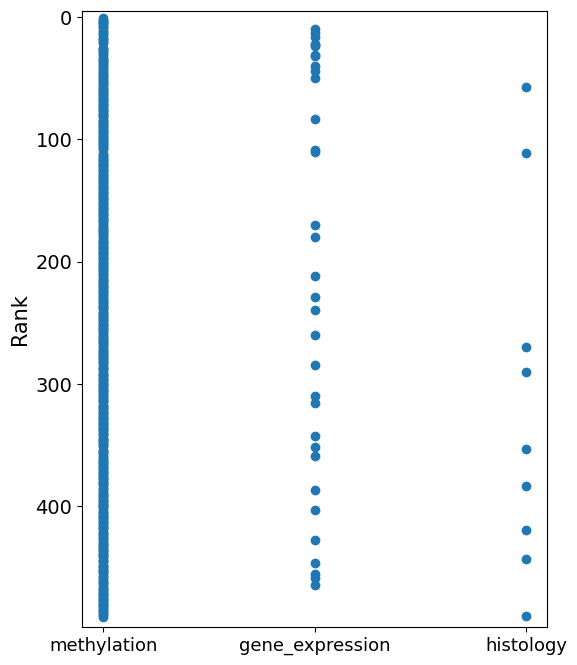

In [236]:
from matplotlib.category import UnitData


shap_values_lung_df_norm['type'] = pd.Categorical(shap_values_lung_df_norm['type'], categories=['methylation', 'gene_expression', 'histology'], ordered=True)

from matplotlib.category import UnitData

plt.figure(figsize=(6, 8))
plt.scatter(shap_values_lung_df_norm['type'],shap_values_lung_df_norm['rank'], xunits=UnitData(['methylation', 'gene_expression', 'histology']))
plt.ylabel('Rank', fontsize=15) 
plt.yticks(fontsize=14)  
plt.xticks(fontsize=13)  

plt.gca().invert_yaxis()
plt.ylim(499, -5) 
plt.show()


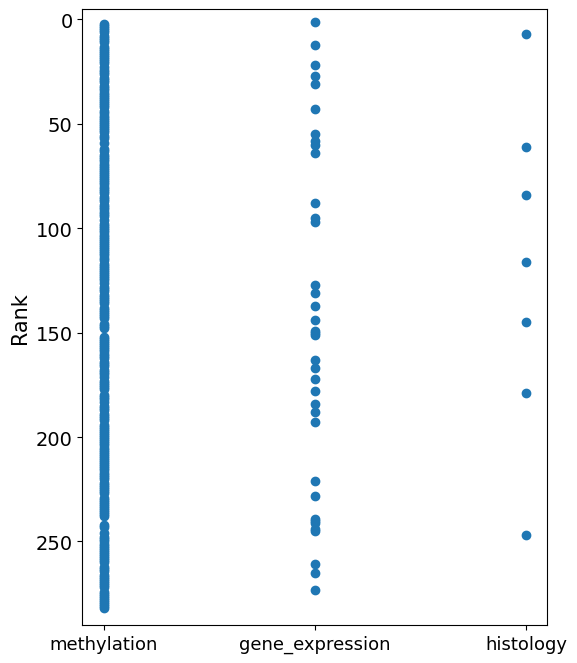

In [237]:
## ovary
shap_values_ovary_df_norm = shap_values_ovary_df_norm.sort_values(by = "normalized_score", ascending=False)


type_values = []
for col_name in shap_values_ovary_df_norm.column_name:
    if col_name.startswith('ENS'):
        type_values.append('gene_expression')
    elif col_name.startswith('cg'):
        type_values.append('methylation')
    else:
        type_values.append('histology')

shap_values_ovary_df_norm['type'] = type_values


# Add 'rank' column
shap_values_ovary_df_norm['rank'] = range(1, shap_values_ovary_df_norm.shape[0] + 1)

plt.figure(figsize=(6, 8))
plt.scatter(shap_values_ovary_df_norm['type'],shap_values_ovary_df_norm['rank'], xunits=UnitData(['methylation', 'gene_expression', 'histology']))
plt.ylabel('Rank', fontsize=15) 
plt.yticks(fontsize=14)  
plt.xticks(fontsize=13)  

plt.gca().invert_yaxis()
plt.ylim(290, -5) 

plt.show()


In [238]:
# Function to convert probes names
def convert_feature_names(labels, probe_info): 
    """Convert probe text to also contain the associated gene/genes"""
    # Create a new column 'genes_clean' by splitting 'UCSC_RefGene_Name' and collapsing unique values
    probe_info['genes_clean'] = probe_info['UCSC_RefGene_Name'].apply(lambda x: ';'.join(sorted(set(str(x).split(';')))) if pd.notnull(x) else '')
    # Create a new column 'feature_full_name' by concatenating 'IlmnID' and 'genes_clean'
    probe_info['feature_full_name'] = probe_info['IlmnID'] + probe_info['genes_clean'].apply(lambda x: ' - ' + x if x != "" else "")
    probe_info = probe_info.set_index("IlmnID")

    for i in range(len(labels)): 
        labels[i] = probe_info.loc[labels[i], "feature_full_name"]
    
    return labels

In [239]:
shap_values_lung_df_norm.head(n = 15)

,column_name,score,normalized_score,type,rank
10,cg27320127,0.745744,3.042005,methylation,1
8,cg03036557,0.680224,2.774740,methylation,2
9,cg06458239,0.542860,2.214411,methylation,3
7,cg12678562,0.534741,2.181289,methylation,4
11,cg02650266,0.505604,2.062436,methylation,5
13,cg16181396,0.499354,2.036942,methylation,6
18,cg06784991,0.447917,1.827124,methylation,7
15,cg12757011,0.432267,1.763283,methylation,8
14,cg00590036,0.419403,1.710811,methylation,9
27407,ENSG00000273542.1,0.380343,1.551478,gene_expression,10


In [240]:
shap_values_ovary_df_norm.head(n = 15)

,column_name,score,normalized_score,type,rank
38326,ENSG00000250846.6,0.563762,2.815325,gene_expression,1
1,cg21242642,0.509572,2.544709,methylation,2
1942,cg12757011,0.440147,2.198016,methylation,3
1376,cg10598456,0.303200,1.514125,methylation,4
1390,cg15341124,0.296335,1.479844,methylation,5
13773,cg08599433,0.259827,1.297526,methylation,6
39783,hist_feature_517,0.250907,1.252982,histology,7
4308,cg15542016,0.232768,1.162403,methylation,8
892,cg01606801,0.227697,1.137079,methylation,9
25866,cg14558712,0.221102,1.104142,methylation,10


In [246]:
## Make plots
shap.summary_plot(
    shap_values_lung_meth_hist_gexp, meth_hist_gexp_test_norm_lung, feature_names=lung_features_meth_hist_gexp, max_display = 15, show = False
)
savefig("../../aging_notes/figures/6.feature_analysis/_lung_meth_hist_gexp_shap_feature_plot_bar.pdf")
close()


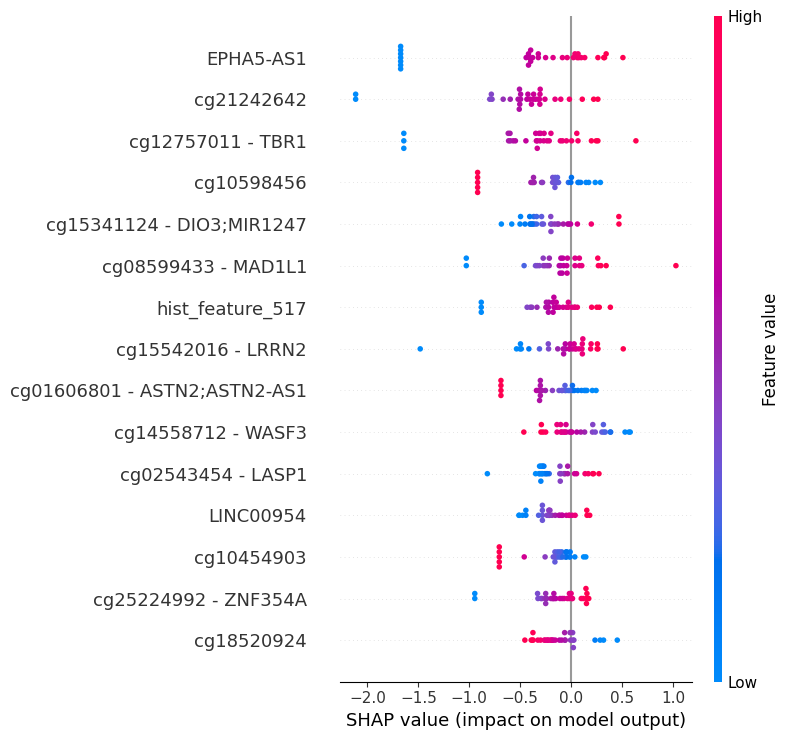

In [247]:
## Make plots
shap.summary_plot(
    shap_values_ovary_meth_hist_gexp, meth_his_test_gexp_norm_ovary, feature_names=ovary_features_meth_hist_gexp, max_display = 15, show = False
)
savefig("../../aging_notes/figures/6.feature_analysis/_ovary_meth_hist_gexp_shap_feature_plot_bar.pdf")